5000 / 100000, loss: 2.6279, Irish: Wrong (Scottish)
10000 / 100000, loss: 2.1496, Spanish: Wrong (Portuguese)
15000 / 100000, loss: 1.6110, Dutch: Correct
20000 / 100000, loss: 2.0646, German: Wrong (French)
25000 / 100000, loss: 2.3266, Polish: Wrong (Japanese)
30000 / 100000, loss: 2.6271, Greek: Wrong (French)
35000 / 100000, loss: 1.2681, Irish: Correct
40000 / 100000, loss: 0.8646, Scottish: Correct
45000 / 100000, loss: 2.9515, Portuguese: Wrong (Italian)
50000 / 100000, loss: 0.9345, Chinese: Correct
55000 / 100000, loss: 1.2164, Italian: Wrong (Spanish)
60000 / 100000, loss: 0.5016, Russian: Correct
65000 / 100000, loss: 5.4789, English: Wrong (Russian)
70000 / 100000, loss: 0.8477, French: Correct
75000 / 100000, loss: 0.4631, Spanish: Correct
80000 / 100000, loss: 0.0699, Russian: Correct
85000 / 100000, loss: 2.1193, Czech: Wrong (German)
90000 / 100000, loss: 0.1734, Chinese: Correct
95000 / 100000, loss: 0.2860, Greek: Correct
100000 / 100000, loss: 2.2728, Czech: Wrong (

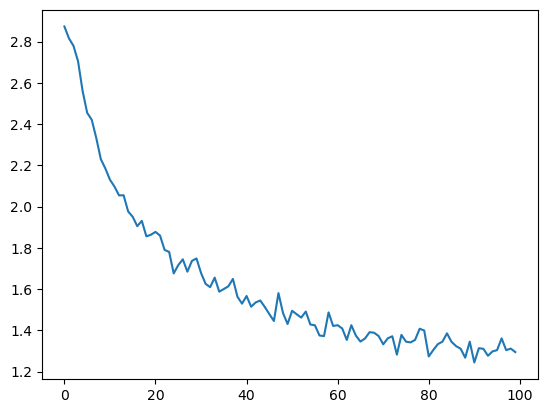

Write name ('quit' if you want to quit): jeong

> jeong
German
Write name ('quit' if you want to quit): kim

> kim
Russian
Write name ('quit' if you want to quit): lee

> lee
French
Write name ('quit' if you want to quit): bai

> bai
Polish
Write name ('quit' if you want to quit): bao

> bao
Spanish
Write name ('quit' if you want to quit): quit


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        # W_hidden: (D_in+H, H), b_hidden: (H,)
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        # W_out: (D_in+H, D_out), b_out: (D_out,)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        # x: (1, D_in)
        combined = torch.cat((x, h), dim=1) # (1, D_in+H)
        hidden = self.i2h(combined) # (1, H)
        output = self.i2o(combined) # (1, D_out)
        output = self.softmax(output) # (1, D_out)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size) # (1, H)
    

def category_from_output(output):
    category_index = torch.argmax(output).item()
    return all_categories[category_index]
    

all_categories, category_lines = load_data()
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, len(all_categories)) # my RNN model
    
loss_fn = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(input_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn.forward(input_tensor[i], hidden)
    # output: (1, 56)
    # category_tensor: (1,)
    loss = loss_fn(output, category_tensor)

    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, word, category_tensor, word_tensor = random_training_example(all_categories, category_lines)
    
    output, loss = train(word_tensor, category_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        pred = category_from_output(output)
        msg = "Correct" if pred==category else f"Wrong ({category})"
        print(f"{i+1} / {n_iters}, loss: {loss:.4f}, {pred}: {msg}")
        
# plot losses
plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_word):
    print(f"\n> {input_word}")
    with torch.no_grad():
        word_tensor = line_to_tensor(input_word)
        hidden = rnn.init_hidden()
        for i in range(word_tensor.size()[0]):
            output, hidden = rnn.forward(word_tensor[i], hidden)
        
        pred_word = category_from_output(output)
        print(pred_word)

while True:
    sentence = input("Write name ('quit' if you want to quit): ")
    if sentence == "quit":
        break
    else:
        predict(sentence)